In [91]:
import os
import math
import glob
import wfdb
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo

from ray import tune, put, get
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial

from scipy import signal
from skorch import NeuralNetRegressor
from torch.utils.data import Dataset, DataLoader
from skimage.restoration import denoise_wavelet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random.seed(1658497162847124986)

data_directory = "./data/CEBS/m001"
model_directory = './models/'
sampling_rate = '10L' # 10ms https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
target_snr_dbs =        [0, 0.5, 1, 3, 7, 10]
target_snr_weights =    (10, 10, 10)

segment_size = '10240L'
segment_size_seconds = int(pd.to_timedelta(segment_size).total_seconds())
segment_size_samples = int(pd.to_timedelta(segment_size).total_seconds() / pd.to_timedelta(sampling_rate).total_seconds())

#num_epochs = 1024
#batch_size = 64
#learning_rate = 0.001
#weight_decay = 0.01

In [93]:
def mse(signal_clean, signal_noisy):
    return mean_squared_error(signal_clean, signal_noisy)

def mae(signal_clean, signal_noisy):
    return mean_absolute_error(signal_clean, signal_noisy)

def rmse(signal_clean, signal_noisy):
    return np.sqrt(mse(signal_clean, signal_noisy))

def snr(signal_clean, signal_noisy):
    return 10 * np.log10(np.sum(signal_clean ** 2) / (np.sum((signal_noisy - signal_clean) ** 2)))

def psnr(signal_clean, signal_noisy):
    return 20 * np.log10(np.max(signal_clean) / (np.sum((signal_noisy - signal_clean) ** 2)))

def prd(signal_clean, signal_noisy):
    return np.sqrt(np.sum((signal_noisy - signal_clean) ** 2) / np.sum(signal_clean ** 2)) * 100

def xcorr(signal_clean, signal_noisy):
    return np.correlate(signal_clean, signal_noisy, mode='same')

In [94]:
def load_cebs(directory):
    record = wfdb.rdsamp(directory)
    data = record[0]
    metadata = record[1]

    frequency = metadata['fs']
    column_names = metadata['sig_name']
    length = metadata['sig_len']

    data = pd.DataFrame(data, columns=column_names)
    data.drop(['I', 'II', 'RESP'], axis=1, inplace=True)

    frequency_string = str(int(1/frequency*1000000)) + 'U'
    index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
    data.set_index(index, inplace=True)
    data = data.resample(sampling_rate).mean().SCG

    data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
    data = data[data.apply(lambda x: len(x) == segment_size_samples)]
    data = data.apply(lambda x: np.array(x))
    
    return data


def load_d2(directory):

    data = pd.read_csv(directory, 
                        sep=',', 
                        header=1, 
                        skiprows=[2],
                        usecols=['Shimmer_D0CD_Timestamp_Shimmer_CAL','Shimmer_D0CD_Accel_LN_Z_CAL'], 
                        dtype={'Shimmer_D0CD_Timestamp_Shimmer_CAL': 'float', 'Shimmer_D0CD_Accel_LN_Z_CAL': 'float'})
    
    data.rename(columns={'Shimmer_D0CD_Timestamp_Shimmer_CAL': 'index', 'Shimmer_D0CD_Accel_LN_Z_CAL': 'SCG'}, inplace=True)

    data['index'] = pd.to_datetime(data['index'], unit='ms')
    data.set_index('index', inplace=True)

    data = data.resample(sampling_rate).mean().SCG

    data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
    data = data[data.apply(lambda x: len(x) == segment_size_samples and not np.isnan(x).any())]
    data = data.apply(lambda x: np.array(x))

    return data

In [95]:
def load_datasets(directory, datasets):

    data = pd.Series(dtype='object')

    if 'CEBS' in datasets:
        filenames = list(dict.fromkeys([x[:-4] for x in glob.glob(r'./data/CEBS/*[0-9][0-9][0-9].*')]))
        data = pd.concat((load_cebs(filename) for filename in filenames), ignore_index=True)
    if 'D2' in datasets:
        filenames =  glob.glob(r'./data/D2/CP-*')
        data2 = pd.concat((load_d2(filename) for filename in filenames), ignore_index=True)
        data = pd.concat((data, data2))

    return data

In [96]:
# https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python

def add_gaussian(data, target_snr_dbs):

    # target_snr_db = random.choices(target_snr_dbs, weights=target_snr_weights, k=1)[0]
    target_snr_db = random.choice(target_snr_dbs)
    # target_snr_db = random.uniform(0, 20) # sample from bigger range provides better results?
    # target_snr_db = 1

    data_watts = data ** 2
    data_avg_watts = np.mean(data_watts)
    data_avg_db = 10 * np.log10(data_avg_watts)

    noise_avg_db = data_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)

    mean_noise = 0
    noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data_watts))

    data_noisy = data + noise
    return data_noisy

def normalize(clean, noise):
    x_concat = np.concatenate((clean, noise))
    min_val = np.min(x_concat)
    max_val = np.max(x_concat)
    y_clean = (clean-min_val) / (max_val - min_val)
    y_noise = (noise-min_val) / (max_val - min_val)
    return y_clean, y_noise, min_val, max_val

# SCG dependent on absolute values
def denormalize(clean, noise, min_val, max_val):
    y_clean = max_val * clean - clean * min_val + min_val
    y_noise = max_val * noise - noise * min_val + min_val
    return y_clean, y_noise


def bandpass(input_signal):
    # https://www.youtube.com/watch?v=juYqcck_GfU
    fs = 100.0 # frequency space
    lowcut = 5.0 # Hz
    highcut = 30.0 # Hz

    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    order = 4

    b, a, = signal.butter(order, [low, high], 'bandpass', analog=False)
    y = signal.filtfilt(b, a, input_signal, axis=0)

    return y

In [97]:
class SCGData(Dataset):

    def __init__(self, transform=None, datasets=None):

        self.min_val = 0
        self.max_val = np.inf

        data = load_datasets('./data/CEBS/', datasets)
        #data = data.resample(sampling_rate).mean().SCG

        data = data.apply(lambda x: bandpass(x))
        data_noise = data.apply(lambda x: add_gaussian(x, target_snr_dbs))
        data = pd.DataFrame({'clean': data, 'noise': data_noise})

        #data_concat = np.concatenate([np.concatenate(data.values[0]), np.concatenate(data.values[1])])
        # https://www.geeksforgeeks.org/data-normalization-with-pandas/
        # self.min_val = np.min(data.values.tolist())
        # self.max_val = np.max(data.values.tolist())

        #data = data.apply(lambda x: normalize(x, self.min_val, self.max_val), axis=1)            
        #data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
        #data = data[data['clean'].apply(lambda x: len(x) == segment_size_samples)]
        #data['clean'] = data['clean'].apply(lambda x: np.array(x))
        #data['noise'] = data['noise'].apply(lambda x: np.array(x))
        
        self.x_data = data.noise.values
        self.y_data = data.clean.values

        self.transform = transform
        self.n_samples = data.shape[0]

    def __getitem__(self, index):
        sample = self.x_data[index].copy(), self.y_data[index].copy()

        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        return self.n_samples


class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.Tensor(inputs), torch.Tensor(targets)

In [98]:
dataset = SCGData(transform=ToTensor(), datasets=['CEBS', 'D2'])

In [99]:
def load_data():
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])

In [100]:
class DeNoise1(nn.Module):
    def __init__(self, layer_size=128):
        super(DeNoise1, self).__init__()

        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.encoder = nn.Sequential(
            nn.Conv1d(1, layer_size, 3, stride=1),
            nn.BatchNorm1d(layer_size),
            nn.ELU(),
            nn.Conv1d(layer_size, int(layer_size/4), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/4), int(layer_size/8), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/8)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/8), int(layer_size/16), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/16)),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(int(layer_size/16), int(layer_size/16), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/16)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/16), int(layer_size/8), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/8)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/8), int(layer_size/4), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/4), int(layer_size), 3, stride=1), 
            nn.BatchNorm1d(int(layer_size)),
            nn.ELU(),
            nn.Conv1d(int(layer_size), 1, 3, stride=1, padding='same'),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//8)
        #encoded = nn.functional.pad(encoded, (0, 0, 0, 0))
        decoded = self.decoder(encoded)
        return decoded

print(segment_size_samples/2 + 7)
print(segment_size_samples/(2*8) + 7)
torchinfo.summary(DeNoise1(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

519.0
71.0


Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise1                                 [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 8, 1016]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 128, 1022]
│    └─BatchNorm1d: 2-2                  [32, 128, 1022]           [32, 128, 1022]
│    └─ELU: 2-3                          [32, 128, 1022]           [32, 128, 1022]
│    └─Conv1d: 2-4                       [32, 128, 1022]           [32, 32, 1020]
│    └─BatchNorm1d: 2-5                  [32, 32, 1020]            [32, 32, 1020]
│    └─ELU: 2-6                          [32, 32, 1020]            [32, 32, 1020]
│    └─Conv1d: 2-7                       [32, 32, 1020]            [32, 16, 1018]
│    └─BatchNorm1d: 2-8                  [32, 16, 1018]            [32, 16, 1018]
│    └─ELU: 2-9                          [32, 16, 1018]            [32, 16, 1018]
│    └─Conv1d: 2-

In [101]:
class DeNoise2(nn.Module):
    def __init__(self, layer_size=128):
        super(DeNoise2, self).__init__()

        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.encoder = nn.Sequential(
            nn.Conv1d(1, layer_size, 8, stride=1),
            nn.BatchNorm1d(layer_size),
            nn.ELU(),
            nn.Conv1d(layer_size, int(layer_size/2), 8, stride=2),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/2), int(layer_size/4), 8, stride=2),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/4), 1, 8, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, int(layer_size/4), 8, stride=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/4), int(layer_size/2), 8, stride=2, output_padding=1),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/2), int(layer_size), 8, stride=2, output_padding=1),
            nn.BatchNorm1d(int(layer_size)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size), 1, 8, stride=1), 
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Conv1d(1, 1, 8, stride=1, padding='same'),
            # nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

torchinfo.summary(DeNoise2(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise2                                 [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 1, 242]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 128, 1017]
│    └─BatchNorm1d: 2-2                  [32, 128, 1017]           [32, 128, 1017]
│    └─ELU: 2-3                          [32, 128, 1017]           [32, 128, 1017]
│    └─Conv1d: 2-4                       [32, 128, 1017]           [32, 64, 505]
│    └─BatchNorm1d: 2-5                  [32, 64, 505]             [32, 64, 505]
│    └─ELU: 2-6                          [32, 64, 505]             [32, 64, 505]
│    └─Conv1d: 2-7                       [32, 64, 505]             [32, 32, 249]
│    └─BatchNorm1d: 2-8                  [32, 32, 249]             [32, 32, 249]
│    └─ELU: 2-9                          [32, 32, 249]             [32, 32, 249]
│    └─Conv1d: 2-10     

In [102]:
class DeNoiseNone(nn.Module):
    def __init__(self, kernel_size=16, filters_1=40, filters_2=20):
        super(DeNoiseNone, self).__init__()
        #self.p1 = segment_size_samples/2 + 7
        #self.p2 = segment_size_samples/64 + 7
        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.kernel_size = kernel_size
        self.filters_1 = filters_1
        self.filters_2 = filters_2

        self.encoder = nn.Sequential(
            nn.Conv1d(1, filters_1, kernel_size, stride=2),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, filters_2, kernel_size, stride=2),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_2, kernel_size, stride=2),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_2, kernel_size, stride=2),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_1, kernel_size, stride=2),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.ConvTranspose1d(1, filters_1, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.ConvTranspose1d(filters_1, filters_2, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_2, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_2, kernel_size, stride=2, output_padding=0),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_1, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, 1, kernel_size, stride=1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        # x = x.view(-1, 1, segment_size_samples)
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//16, 1)
        #encoded = nn.functional.pad(encoded, (0, 0, 1, 0))
        decoded = self.decoder(encoded)
        return decoded


print(segment_size_samples/2 + 7)
print(segment_size_samples/(2*16) + 7)
torchinfo.summary(DeNoise2(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

519.0
39.0


Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise2                                 [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 1, 242]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 128, 1017]
│    └─BatchNorm1d: 2-2                  [32, 128, 1017]           [32, 128, 1017]
│    └─ELU: 2-3                          [32, 128, 1017]           [32, 128, 1017]
│    └─Conv1d: 2-4                       [32, 128, 1017]           [32, 64, 505]
│    └─BatchNorm1d: 2-5                  [32, 64, 505]             [32, 64, 505]
│    └─ELU: 2-6                          [32, 64, 505]             [32, 64, 505]
│    └─Conv1d: 2-7                       [32, 64, 505]             [32, 32, 249]
│    └─BatchNorm1d: 2-8                  [32, 32, 249]             [32, 32, 249]
│    └─ELU: 2-9                          [32, 32, 249]             [32, 32, 249]
│    └─Conv1d: 2-10     

In [103]:
num_epochs = 10000
train_dataset, test_dataset = load_data()

In [104]:
def train(config, train_dataset, model_num, is_tune=False, data_id=None, checkpoint_dir=None, data_dir=None):

    if model_num in [1]:
        model = DeNoise1(layer_size=config['layer_size'])
    elif model_num in [2, 3]:
        model = DeNoise2(layer_size=config['layer_size'])
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['wd'])

    # if checkpoint_dir != None:
    #    model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
    #    model.load_state_dict(model_state)
    #    optimizer.load_state_dict(optimizer_state)

    if data_id:
        train_dataset = get(data_id)

    test_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - test_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [test_size, val_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)

    n_total_steps = len(train_loader)
    min_val_loss = np.inf

    train_loss_values = []
    val_loss_values = []
    epoch_values = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        epoch_steps = 0
        for i, (inputs, lables) in enumerate(train_loader):
            
            lables, inputs, _, _ = normalize(lables, inputs)

            if model_num == 3:
                inputs = denoise_wavelet(inputs, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                
            # inputs, lables = torch.from_numpy(inputs), torch.from_numpy(lables)
            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)
            inputs, lables = inputs.to(device), lables.to(device)

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, lables)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            epoch_steps += 1

        train_loss_values.append(train_loss)

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, (inputs, lables) in enumerate(val_loader):

            lables, inputs, _, _ = normalize(lables, inputs)

            if model_num == 3:
                inputs = denoise_wavelet(inputs, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')

            # inputs, lables = torch.from_numpy(inputs), torch.from_numpy(lables)
            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)
            inputs, lables = inputs.to(device), lables.to(device)

            output = model(inputs)
            loss = criterion(output, lables)
            val_loss += loss.item()
            val_steps += 1
            
        val_loss_values.append(val_loss)
        epoch_values.append(epoch)

        if is_tune:
            with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, 'checkpoint')
                torch.save((model.state_dict(), optimizer.state_dict()), path)
            
            tune.report(loss=(val_loss / val_steps))
        else:
            print(f'epoch {epoch + 1} / {num_epochs}, train loss = {(train_loss / len(train_loader)):.10f}, val loss = {(val_loss / len(val_loader)):.10f}')
            if min_val_loss > val_loss:
                print(f'\tval loss decreased from {min_val_loss:.10f} to {val_loss:.10f}')
                min_val_loss = val_loss

                if model_num == 1:
                    torch.save(model.state_dict(), os.path.join(model_directory, 'model_1.pth'))
                    df = pd.DataFrame({'epoch': epoch_values,'train_loss': train_loss_values, 'val_loss': val_loss_values})
                    df.to_csv('./models/loss_1.csv') 
                elif model_num == 2:
                    torch.save(model.state_dict(), os.path.join(model_directory, 'model_2.pth'))
                    df = pd.DataFrame({'epoch': epoch_values,'train_loss': train_loss_values, 'val_loss': val_loss_values})
                    df.to_csv('./models/loss_2.csv')
                elif model_num == 3:
                    torch.save(model.state_dict(), os.path.join(model_directory, 'model_3.pth'))
                    df = pd.DataFrame({'epoch': epoch_values,'train_loss': train_loss_values, 'val_loss': val_loss_values})
                    df.to_csv('./models/loss_3.csv')  

In [105]:
# https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html

num_samples = 64 # sample data multiple times
max_num_epochs = 128

config = {
    'lr': tune.loguniform(1e-5, 1e-1),
    'wd': 0,
    'batch_size': tune.choice([8, 16, 32]),
    'layer_size': tune.choice([128])
}

scheduler = ASHAScheduler(metric='loss', mode='min', max_t=max_num_epochs, grace_period=1, reduction_factor=2)
reporter = CLIReporter(metric_columns=['loss', 'training_iteration'])
data_id = put(train_dataset)
#result = tune.run(
    partial(train, train_dataset=None, model_num=2, is_tune=True, data_id=data_id, checkpoint_dir=None, data_dir=None),
    resources_per_trial={'cpu': 4, 'gpu': 1},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter
)

best_trial = result.get_best_trial('loss', 'min', 'last')
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))

best_trained_model =  DeNoise2().to(device)

best_checkpoint_dir = best_trial.checkpoint.dir_or_data
model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, 'checkpoint'))
best_trained_model.load_state_dict(model_state)

IndentationError: unexpected indent (4043442718.py, line 17)

In [107]:
# {'lr': 0.0006948120282769452, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.0013009571703150868

# {'lr': 0.0011704653180570925, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0010375047129388723
# {'lr': 0.0025766834278764987, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.0018318614236014928

# train({'lr': 0.0007, 'wd': 0, 'layer_size': 128, 'batch_size': 16}, train_dataset, 1)
# train({'lr': 0.005, 'wd': 0, 'layer_size': 64, 'batch_size': 16}, train_dataset, 2)
# train({'lr': 0.0005, 'wd': 0, 'layer_size': 128, 'batch_size': 8}, train_dataset, 3)

epoch 1 / 10000, train loss = 0.0024917593, val loss = 0.0032626312
	val loss decreased from inf to 0.3132125907
epoch 2 / 10000, train loss = 0.0024094851, val loss = 0.0032335822
	val loss decreased from 0.3132125907 to 0.3104238871
epoch 3 / 10000, train loss = 0.0022485521, val loss = 0.0029354159
	val loss decreased from 0.3104238871 to 0.2817999225
epoch 4 / 10000, train loss = 0.0022632363, val loss = 0.0027330970
	val loss decreased from 0.2817999225 to 0.2623773158
epoch 5 / 10000, train loss = 0.0023901410, val loss = 0.0023575414
	val loss decreased from 0.2623773158 to 0.2263239757
epoch 6 / 10000, train loss = 0.0025036241, val loss = 0.0034947078


In [ ]:
def plot_result_bar(data, labels, xlabel, ylabel, title):
    plt.xticks(range(len(data[0])), labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    width = 0.1

    for i in range(len(target_snr_dbs) + 1):
        plt.bar(np.arange(len(data[i])) + i * width, data[i], width=width)
    plt.legend(target_snr_dbs + ['all'])
    plt.show()

def save_results(results):

    if not os.path.exists('./results'):
        os.mkdir('./results')

    # run_name = str(len(os.listdir('./results')))
    # working_dir = os.path.join('./results', run_name)
    # working_dir = os.mkdir(working_dir)

    working_dir = os.path.join('./results', '0')

    # SNR imp
    data = [[np.mean(results[method][scope]['snr_imp']) for method in results.keys()] for scope in target_snr_dbs + ['all']]
    plot_result_bar(data, results.keys(), 'Denoising Method', 'SNR Improvement (dB)', 'Mean SNR Improvement')

    # MSE
    data = [[np.mean(results[method][scope]['mse']) for method in results.keys()] for scope in target_snr_dbs + ['all']]
    plot_result_bar(data, results.keys(), 'Denoising Method', 'MSE', 'Mean MSE')

    # RMSE
    data = [[np.mean(results[method][scope]['rmse']) for method in results.keys()] for scope in target_snr_dbs + ['all']]
    plot_result_bar(data, results.keys(), 'Denoising Method', 'RMSE', 'Mean RMSE')

    # MAE
    data = [[np.mean(results[method][scope]['mae']) for method in results.keys()] for scope in target_snr_dbs + ['all']]
    plot_result_bar(data, results.keys(), 'Denoising Method', 'MAE', 'Mean MAE')

    # PSNR
    data = [[np.mean(results[method][scope]['psnr']) for method in results.keys()] for scope in target_snr_dbs + ['all']]
    plot_result_bar(data, results.keys(), 'Denoising Method', 'PSNR', 'Mean PSNR')

    # xcorr

    # PRD
    data = [[np.mean(results[method][scope]['prd']) for method in results.keys()] for scope in target_snr_dbs + ['all']]
    plot_result_bar(data, results.keys(), 'Denoising Method', 'PRD', 'Mean PRD')


    # CPU Consumption
    data = [np.mean(results[method]['all']['cpu_time']) * 1000 for method in results.keys()]

    labels = results.keys()
    plt.xticks(range(len(data)), labels)
    plt.xlabel('Denoising Method')
    plt.ylabel('CPU Time (ms)')
    plt.title('Mean CPU Time')

    plt.bar(np.arange(len(data)), data)
    plt.show()

4052
*** AE1 ***
451
SNR IMP 1.717718380674753
RMSE 1.2358761
PRD 76.60295421426946
CPU TIME 0.0013860901529950875

4052
*** WD ***
451
SNR IMP 2.216790577937785
RMSE 1.1146715
PRD 68.43589282617336
CPU TIME 0.0005272456984478629

4052
*** AE2 ***
451
SNR IMP 0.5037800900606095
RMSE 1.3647677
PRD 86.82841371802692
CPU TIME 0.0012806902217302166



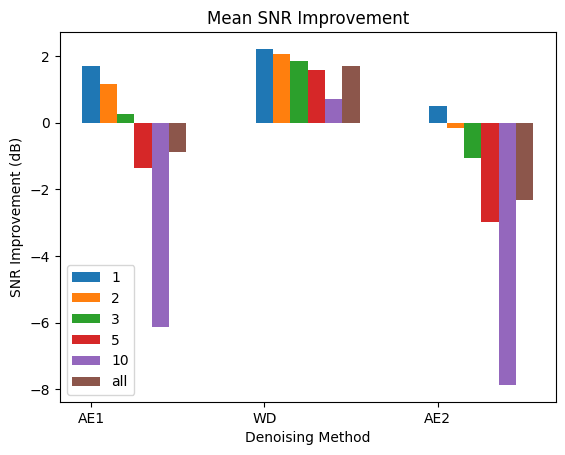

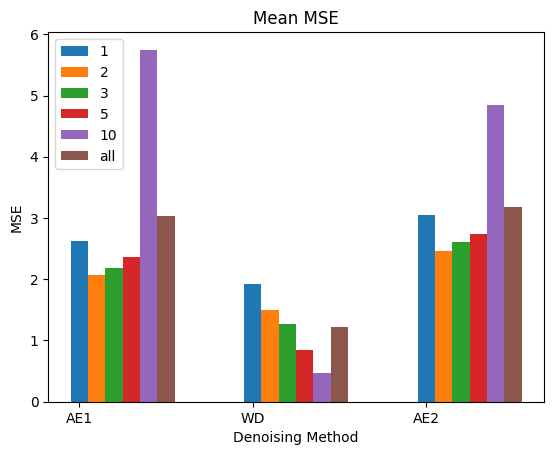

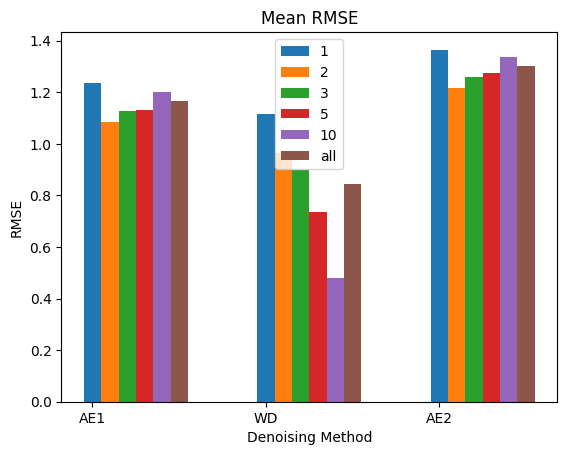

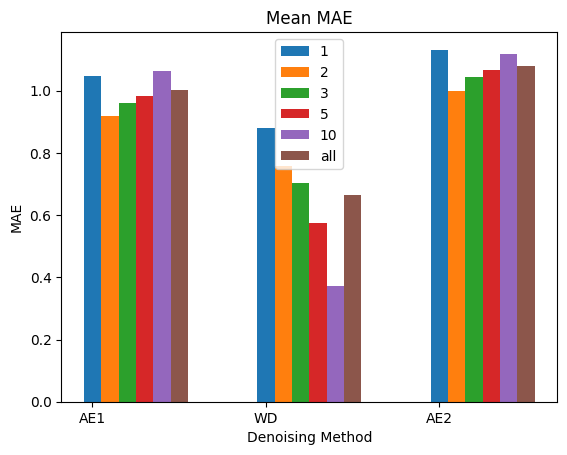

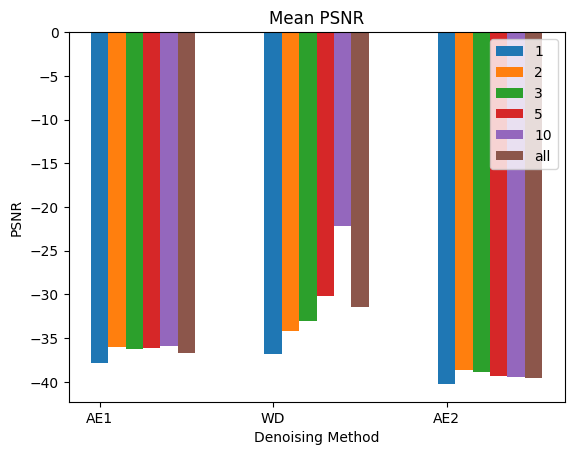

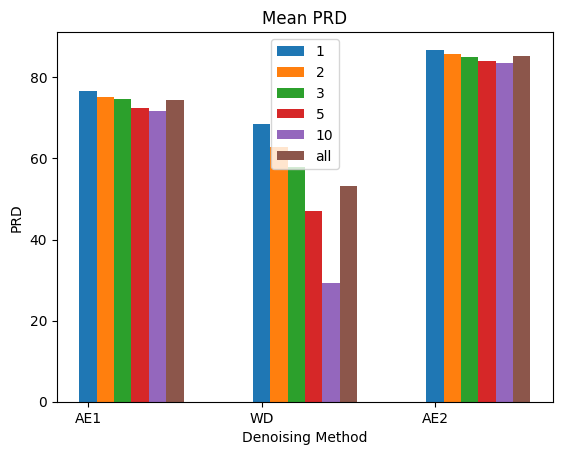

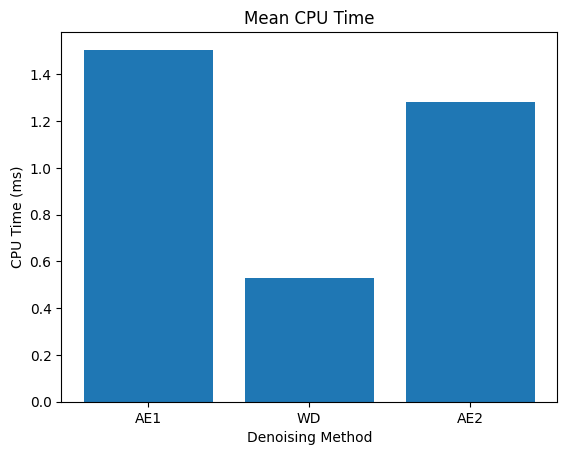

In [ ]:
def reverse(x):
    return dataset.max_val * x - x * dataset.min_val + dataset.min_val

def test(config):
    
    with torch.no_grad():

        ae1 = DeNoise1(layer_size=128).to(device)
        ae1.load_state_dict(torch.load(os.path.join(model_directory, 'model_1.pth')))
        ae1.eval()

        ae2 = DeNoise2(layer_size=64).to(device)
        ae2.load_state_dict(torch.load(os.path.join(model_directory, 'model_2.pth')))
        ae2.eval()

        ae3 = DeNoise2(layer_size=128).to(device)
        # ae3.load_state_dict(torch.load(os.path.join(model_directory, 'model_3.pth')))
        ae3.eval()

        results = {}

        for method in config['methods']:
            
            results[method] = {}
            for target in target_snr_dbs + ['all']:
                results[method][target] = {
                    'result': [],
                    'snr_imp': [],
                    'mse': [],
                    'rmse': [],
                    'mae': [],
                    'psnr': [],
                    'xcorr': [],
                    'prd': [],
                    'cpu_time': []
                }
            i = 0
            for noise, clean in test_dataset:

                cpu_time = 0
                clean, noise, min_val, max_val = normalize(clean, noise)

                if method == 'AE1':
                    
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device)

                    cpu_time_start = time.process_time()
                    predicted = ae1(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                elif method == 'AE2':
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device)

                    cpu_time_start = time.process_time()
                    predicted = ae2(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                elif method == 'WD':
                    noise = noise.numpy()

                    cpu_time_start = time.process_time()
                    predicted = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start
                elif method == 'AE1+WD':
                    noise = noise.numpy()

                    cpu_time_start = time.process_time()
                    predicted = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                    noise = torch.from_numpy(predicted)
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device)
                    predicted = ae1(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                else:
                    break

                clean_old = clean.numpy()
                clean, noise = denormalize(clean_old, noise, min_val, max_val)
                clean, predicted = denormalize(clean_old, predicted, min_val, max_val)

                snr_data = snr(clean, noise)
                for target in target_snr_dbs + ['all']:
                    if (str(target) == 'all') or (snr_data > (target - 0.8) and snr_data < (target + 0.8)):
                        i += 1
                        results[method][target]['result'].append(predicted)
                        results[method][target]['snr_imp'].append([snr(clean, predicted) - snr_data])
                        results[method][target]['mse'].append([mse(clean, predicted)])
                        results[method][target]['rmse'].append([rmse(clean, predicted)])
                        results[method][target]['mae'].append([mae(clean, predicted)])
                        results[method][target]['psnr'].append([psnr(clean, predicted)])
                        # xcorr
                        results[method][target]['prd'].append([prd(clean, predicted)])
                        results[method][target]['cpu_time'].append(cpu_time)
            
            print(i)
            value = 1
            print('*** ' + method + ' ***')
            print(len(results[method][value]['result']))
            print('SNR IMP ' + str(np.mean(results[method][value]['snr_imp'])))
            print('RMSE ' + str(np.mean(results[method][value]['rmse'])))
            print('PRD ' + str(np.mean(results[method][value]['prd'])))
            print('CPU TIME ' + str(np.mean(results[method][value]['cpu_time'])))
            print()

        save_results(results)


config = {
    'methods': ['AE1', 'WD', 'AE2'] # 'AE1+WD']
}
test(config)

2.6737428
2.4297152

1.3041918
1.3138688

2.454221248626709
2.8698641061782837
1.5749271214008331

-50.48200607299805
-49.65072154998779

[799.6444  931.81537 797.7808  ... 244.60397 646.91016 861.17267]
[469.98065 547.4593  480.82632 ... 162.59268 445.2161  591.7456 ]



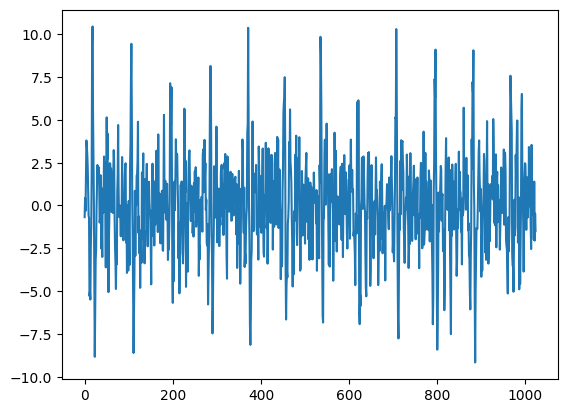

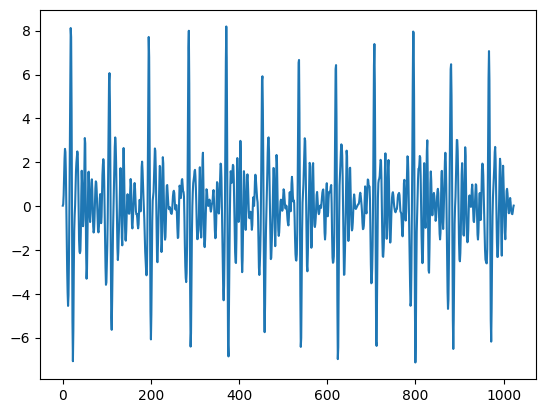

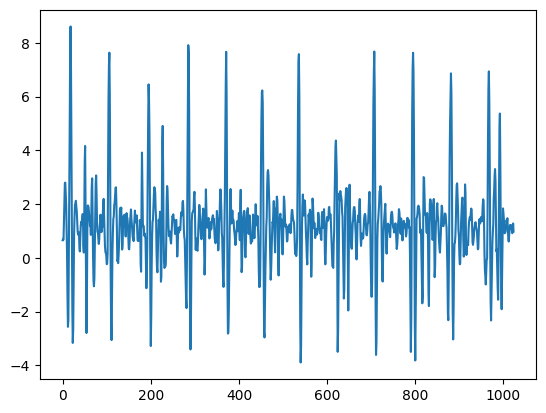

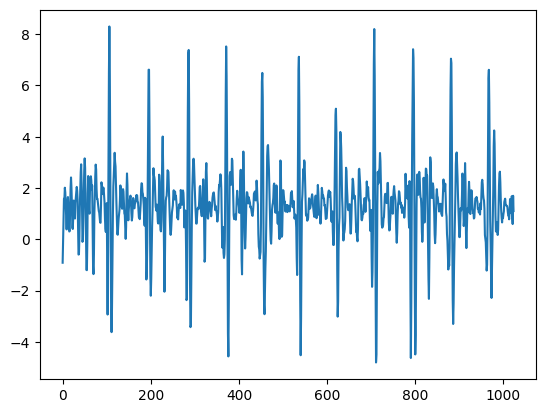

In [ ]:
model1 = DeNoise1(layer_size=128).to(device)
model1.load_state_dict(torch.load(os.path.join(model_directory, 'model_1.pth')))

model2 = DeNoise2(layer_size=64).to(device)
model2.load_state_dict(torch.load(os.path.join(model_directory, 'model_2.pth')))

model1.eval()
model2.eval()

with torch.no_grad():
    
    i = 0
    i = random.choice(range(0, len(test_dataset)))
    noise = test_dataset[i][0]
    clean = test_dataset[i][1]

    clean, noise, min_val, max_val = normalize(clean, noise)
    clean = clean.reshape(-1, 1, segment_size_samples).to(device)
    noise = noise.reshape(-1, 1, segment_size_samples).to(device)

    predicted = model1(noise).to('cpu').reshape(segment_size_samples).numpy()
    predicted2 = model2(noise).to('cpu').reshape(segment_size_samples).numpy()
    clean_old = clean.to('cpu').reshape(segment_size_samples).numpy()
    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
    # predicted2 = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
    
    clean, noise = denormalize(clean_old, noise, min_val, max_val)
    clean, predicted = denormalize(clean_old, predicted, min_val, max_val)
    clean, predicted2 = denormalize(clean_old, predicted2, min_val, max_val)

    from_val = 0
    to_val = 1024
    #noise = reverse(noise[from_val:to_val])
    #clean = reverse(clean[from_val:to_val])
    #predicted = reverse(predicted[from_val:to_val])
    #predicted2 = reverse(predicted2[from_val:to_val])

    print(mse(clean, noise))
    print(mse(clean, predicted))
    print()

    print(mae(clean, noise))
    print(mae(clean, predicted))
    print()

    print(snr(clean, noise))
    print(snr(clean, predicted))
    print(snr(clean, predicted2))
    print()

    print(psnr(clean, noise))
    print(psnr(clean, predicted))
    print()

    print(xcorr(clean, noise))
    print(xcorr(clean, predicted))
    print()
    
    time_from = 0
    time_to = 1024

    plt.plot(range(time_to)[time_from:time_to], noise[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], clean[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], predicted[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], predicted2[time_from:time_to])
    plt.show()

    torch.cuda.empty_cache()